In [91]:
import random
import time
import matplotlib.pyplot as plt

random.seed(14)

In [92]:
# Допоміжні функції
def find_zero(state):
    for i, row in enumerate(state):
        for j, val in enumerate(row):
            if val == 0:
                return i, j

def copy_state(state):
    return [row[:] for row in state]

def h1(state):
    goal_state = [
        [1, 2, 3],
        [4, 5, 6],
        [7, 8, 0]
    ]
    count = 0
    for i in range(3):
        for j in range(3):
            if state[i][j] != 0 and state[i][j] != goal_state[i][j]:
                count += 1
    return count

def generate_neighbors(state):
    neighbors = []
    x, y = find_zero(state)
    moves = [(x - 1, y), (x + 1, y), (x, y - 1), (x, y + 1)]  # зверху, знизу, зліва, зправа

    for move in moves:
        if 0 <= move[0] < 3 and 0 <= move[1] < 3:
            new_state = copy_state(state)
            new_state[x][y], new_state[move[0]][move[1]] = new_state[move[0]][move[1]], new_state[x][y]
            neighbors.append(new_state)

    return neighbors

In [93]:
# Алгоритм LDFS
def LDFS(state, goal, depth, limit, nodes_generated, max_nodes_in_memory, path=[]):
    nodes_generated[0] += 1
    max_nodes_in_memory[0] = max(max_nodes_in_memory[0], len(path))
    
    if state == goal:
        return path + [state]

    if depth == limit:
        return None

    for neighbor in generate_neighbors(state):
        if neighbor not in path: 
            result = LDFS(neighbor, goal, depth + 1, limit, nodes_generated, max_nodes_in_memory, path + [state])
            if result is not None:
                return result

    return None

In [95]:
# Функція для перемішування початкового стану
def shuffle_state(state, moves=100):
    for _ in range(moves):
        neighbors = generate_neighbors(state)
        state = random.choice(neighbors)
    return state

# Функція для виконання експерименту
def run_experiment(initial_state, goal_state, limit):
    start_time = time.time()
    nodes_generated = [0]
    max_nodes_in_memory = [0]
    result = LDFS(initial_state, goal_state, 0, limit, nodes_generated, max_nodes_in_memory)
    end_time = time.time()
    return {
        "initial_state": initial_state,
        "time": end_time - start_time,
        "nodes_generated": nodes_generated[0],
        "max_nodes_in_memory": max_nodes_in_memory[0],
        "result": "Success" if result else "Failure"
    }


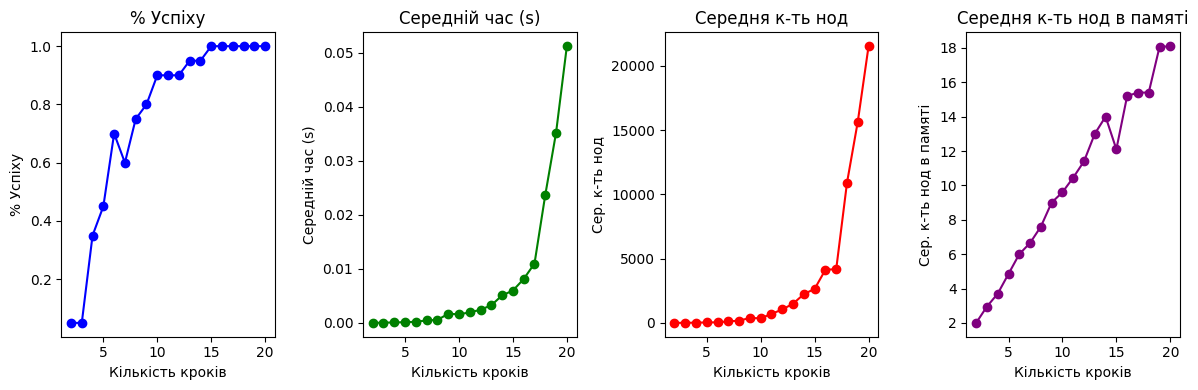

Optimal Step Limit: 3
Success Rate at Optimal Steps: 0.05
Average Time at Optimal Steps: 0.0 seconds
Average Nodes Generated at Optimal Steps: 8.5
Average Max Nodes in Memory at Optimal Steps: 2.0


In [96]:
# запуск 
goal_state = [
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 0]
]

def analyze_results(steps_range, success_rates, avg_times, avg_nodes_generated, avg_max_nodes_in_memory):
    threshold = 0.01 
    optimal_steps = None
    for i in range(1, len(success_rates)):
        if success_rates[i] - success_rates[i-1] < threshold:
            optimal_steps = steps_range[i]
            break
    
    if not optimal_steps:
        optimal_steps = steps_range[-1]

    print(f"Optimal Step Limit: {optimal_steps}")
    print(f"Success Rate at Optimal Steps: {success_rates[optimal_steps//2 - 1]}")
    print(f"Average Time at Optimal Steps: {avg_times[optimal_steps//2 - 1]} seconds")
    print(f"Average Nodes Generated at Optimal Steps: {avg_nodes_generated[optimal_steps//2 - 1]}")
    print(f"Average Max Nodes in Memory at Optimal Steps: {avg_max_nodes_in_memory[optimal_steps//2 - 1]}")
    
def run_experiments(goal_state, num_experiments):
    steps_range = range(2, 21, 1) 
    success_rates = []
    avg_times = []
    avg_nodes_generated = []
    avg_max_nodes_in_memory = []

    for steps_limit in steps_range:
        total_time = 0
        total_nodes_generated = 0
        total_max_nodes_in_memory = 0
        successes = 0

        for experiment in range(num_experiments):
            initial_state = shuffle_state(goal_state, moves=20)
            experiment_result = run_experiment(initial_state, goal_state, steps_limit)

            if experiment_result['result'] == 'Success':
                successes += 1
            total_time += experiment_result['time']
            total_nodes_generated += experiment_result['nodes_generated']
            total_max_nodes_in_memory += experiment_result['max_nodes_in_memory']

        success_rates.append(successes / num_experiments)
        avg_times.append(total_time / num_experiments)
        avg_nodes_generated.append(total_nodes_generated / num_experiments)
        avg_max_nodes_in_memory.append(total_max_nodes_in_memory / num_experiments)

    # Графік успішності
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 4, 1)
    plt.plot(steps_range, success_rates, marker='o', linestyle='-', color='blue')
    plt.xlabel('Кількість кроків')
    plt.ylabel('% Успіху')
    plt.title('% Успіху')

    # Графік середнього часу виконання
    plt.subplot(1, 4, 2)
    plt.plot(steps_range, avg_times, marker='o', linestyle='-', color='green')
    plt.xlabel('Кількість кроків')
    plt.ylabel('Середній час (s)')
    plt.title('Середній час (s)')

    # Графік середньої кількості згенерованих вузлів
    plt.subplot(1, 4, 3)
    plt.plot(steps_range, avg_nodes_generated, marker='o', linestyle='-', color='red')
    plt.xlabel('Кількість кроків')
    plt.ylabel('Сер. к-ть нод')
    plt.title('Середня к-ть нод')

    # Графік середньої максимальної кількості вузлів в пам'яті
    plt.subplot(1, 4, 4)
    plt.plot(steps_range, avg_max_nodes_in_memory, marker='o', linestyle='-', color='purple')
    plt.xlabel('Кількість кроків')
    plt.ylabel('Сер. к-ть нод в памяті')
    plt.title('Середня к-ть нод в памяті')

    plt.tight_layout()
    plt.show()
    
    # Call this function after running experiments and collecting data
    analyze_results(steps_range, success_rates, avg_times, avg_nodes_generated, avg_max_nodes_in_memory)

run_experiments(goal_state, 20)

